#### Recommendation System using Udemy Dataset

#### Algo
+ Cosine Similarity
+ Linear Similarity

#### Workflow
+ Dataset
+ Vectorized our dataset
+ Cosine Similarity Matrix ('title', 'subject')
+ Linear Similarity Matrix
+ ID,Score
+ Recommend
+ Filters

In [1]:

import pandas as pd
import neattext.functions as nfx
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline
import re

from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel


df = pd.read_csv("udemy_courses.csv")
df = df[['course_id', 'course_title', 'is_paid', 'price', 'level','content_duration', 'subject']]



def prepare_content_duration(x):
    temp = r"[-+]?(?:\d*\.*\d+)"
    try:
        if "hour" in x:
            return int(float(re.findall(temp, x)[0]) * 60)
        elif 'mins':
            return int(re.findall(temp, x)[0])
        else:
            return 100
    except:
        return 100

### prepare duration
df["content_duration"] = df["content_duration"].apply(prepare_content_duration)
df['price'] = df['price'].apply(lambda x: int(0) if x.lower() in ('free', 'true')  else int(x))
df = df[df['level'] != '52']
# Clean Text:stopwords,special charac
df['clean_course_title'] = df['course_title'].apply(lambda x: x.lower()).apply(nfx.remove_stopwords).apply(nfx.remove_special_characters)

In [2]:
df.head()

,course_id,course_title,is_paid,price,level,content_duration,subject,clean_course_title
0,1070968,Ultimate Investment Banking Course,True,200,All Levels,90,Business Finance,ultimate investment banking course
1,1113822,Complete GST Course & Certification - Grow You...,True,75,All Levels,2340,Business Finance,complete gst course certification grow practice
2,1006314,Financial Modeling for Business Analysts and C...,True,45,Intermediate Level,150,Business Finance,financial modeling business analysts consultants
3,1210588,Beginner to Pro - Financial Analysis in Excel ...,True,95,All Levels,180,Business Finance,beginner pro financial analysis excel 2017
4,1011058,How To Maximize Your Profits Trading Options,True,200,Intermediate Level,120,Business Finance,maximize profits trading options


<Axes: ylabel='Frequency'>

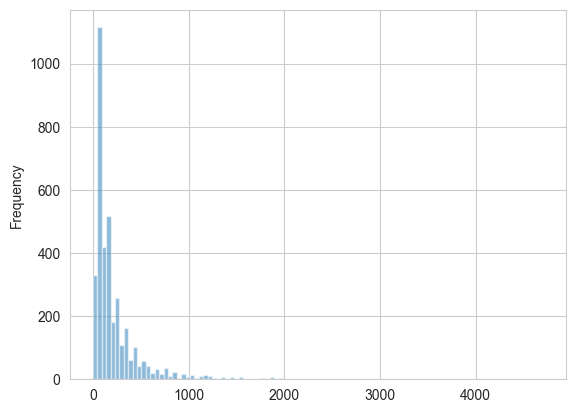

In [3]:
%matplotlib inline
df["content_duration"].plot.hist(bins=102, alpha=0.5)

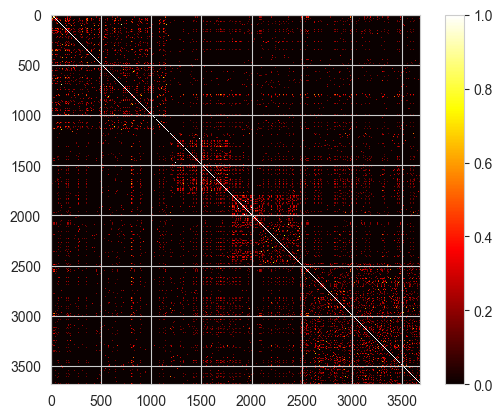

In [4]:
# Vectorize our Text
count_vect = CountVectorizer()
cv_mat = count_vect.fit_transform(df['clean_course_title'])

# Cosine Similarity Matrix
cosine_sim_mat = cosine_similarity(cv_mat)
#cosine_sim_mat
plt.imshow(cosine_sim_mat, cmap='hot', interpolation='nearest')
# sns.heatmap(cosine_sim_mat, linewidth=0.5)
plt.colorbar()
plt.show()

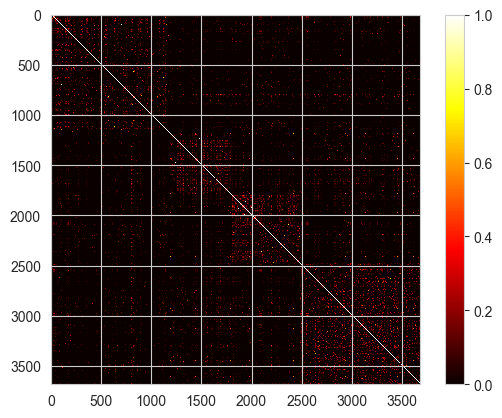

In [5]:
# Vectorize tfidf
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['course_title'])

# Tfidf Similarity Matrix
tfidf_sim_mat = linear_kernel(tfidf_matrix, tfidf_matrix)

plt.imshow(tfidf_sim_mat, cmap='hot', interpolation='nearest')
# sns.heatmap(cosine_sim_mat, linewidth=0.5)
plt.colorbar()
plt.show()

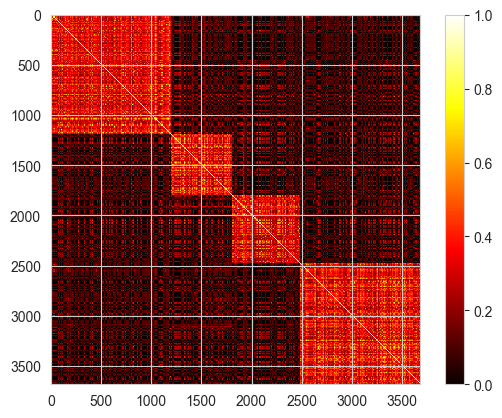

In [6]:
features = ['clean_course_title', 'subject', 'level']

def create_soup(x):
    return ''.join(x['clean_course_title']) + ' '  + ''.join(x['level']) + ' '  + ''.join(x['subject'])

df['soup'] = df.apply(create_soup, axis=1)


count = CountVectorizer(stop_words='english')
cosine_sim_mat2 = cosine_similarity(count.fit_transform(df['soup']))
# Cosine Similarity Matrix
plt.imshow(cosine_sim_mat2, cmap='hot', interpolation='nearest')
# sns.heatmap(cosine_sim_mat, linewidth=0.5)
plt.colorbar()
plt.show()

# CORE

In [11]:
from dataclasses import dataclass

@dataclass
class Recommendation:
     course_title: str
     top: str
     content_duration_term: str 
     level: str 
     subject: str 
     is_paid: bool
     is_dislike: bool


class RS:
    def __init__(self, df):
        self._dump = df.copy(deep=True)
        self.df = df.copy(deep=True)
        
    def reset(self):
        self.df = self._dump.copy(deep=True)

    def head(self, n: int = 10):
        self.df.head(n)
    
    @staticmethod
    def apply_filters(df, content_duration_term=None, level=None, subject=None, is_paid=None):
        df = df.copy(deep=True)
        content_duration_set = {'short':lambda x: int(x) <= 2*60, 'medium': lambda x: 10*60 < x <=100*60, 'long':  lambda x: 100*60 <= x }
        
        if level:
            df = df[df['level'].apply(lambda x: x == level)]
        if is_paid is not None:
            df = df[df['is_paid'].apply(lambda x: x.lower() == str(is_paid).lower())]
        if content_duration_term:
            df = df[df['content_duration'].apply(content_duration_set[content_duration_term])]
        if subject:
            df = df[df['subject'].apply(lambda x: x.lower() == subject.lower())]
        
        return df
    
    def _recommend_course(self, r: Recommendation, is_composed: bool):
        data = self.df.copy(deep=True)
        
        print(f'debug input: course_title:{r.course_title} top:{r.top} term:{r.content_duration_term} level:{r.level} subject:{r.subject} is_paid:{r.is_paid}')
    
        # ID for title
        course_indices = pd.Series(data.index,index=data['course_title'])
        idx = course_indices[r.course_title]
        target = data.iloc[idx]
        data.drop(index=idx, inplace=True)
        
        # Filter
        data = self.apply_filters(data, r.content_duration_term, r.level, r.subject, r.is_paid)
        data.reset_index(drop= True, inplace=True)
    
        idx = len(data.index)
        data.loc[idx] = target
        
        # Version
        if is_composed:   
            def create_soup(x):
                return f"{''.join(x['clean_course_title'])} {''.join(x['level'])} {''.join(x['subject'])}"
            
            data['soup'] = data.apply(create_soup, axis=1)
            count = CountVectorizer()
            cosine_sim_mat = cosine_similarity(count.fit_transform(data['soup']))
        else:
            count_vect = CountVectorizer()
            cosine_sim_mat = cosine_similarity(count_vect.fit_transform(data['clean_course_title']))
    
        # Scores
        scores = list(enumerate(cosine_sim_mat[idx]))
        sorted_scores = sorted(scores,key=lambda x:x[1],reverse=True)
        # Recomm
        selected_course_indices = [i[0] for i in sorted_scores[1:]]
        selected_course_scores = [i[1] for i in sorted_scores[1:]]
        data = data.iloc[selected_course_indices] 
        data['similarity_scores'] = selected_course_scores
        
        if r.is_dislike:
            data = data.iloc[::-1]
        return  data.head(r.top)
        
    def _prepare_recommendation(self):
        terms = ['short', 'medium', 'long']
        subjects = list(self.df['subject'].unique())
        levels = list(self.df['level'].unique())
    
        course_title = input("enter course_title:")
        top = input(f"enter top:")
        top = int(top) if top != '' else 10
        
        term_idx = input(f"chose by index content_duration:{terms}")
        content_duration_term = None
        if term_idx != '':   
            content_duration_term = terms[int(term_idx)]
        
        subject_idx = input(f"chose by index subject:{subjects}")
        subject = None
        if subject_idx:
            subject = subjects[int(subject_idx)]
        
            
        level_idx = input(f"enter level {levels}:")
        level = None
        if level_idx:
            level = levels[int(level_idx)]
            
        is_paid = input("enter is_paid (yes/no):")
        if is_paid.lower() == 'yes':
            is_paid = True
        elif is_paid.lower() == 'no':
            is_paid = False
        else:
            is_paid = None
       
        is_dislike = input("enter is_dislike (yes/no):")
        if is_dislike.lower() == 'yes':
            is_paid = True
        elif is_dislike.lower() == 'no':
            is_dislike = False
        else:
            is_dislike = None
        return Recommendation(course_title=course_title, top=top, content_duration_term=content_duration_term, level=level, subject=subject, is_paid=is_paid, is_dislike=is_dislike)
    
    def recommend_course(self, is_composed=False):
        recom = self._prepare_recommendation()
        return self._recommend_course(recom, is_composed)


In [15]:
rs = RS(df) # Ultimate Investment Banking Course
recom = rs.recommend_course(is_composed=False)
recom = rs.apply_filters(recom, is_paid=True)
recom.head(3)

debug input: course_title:Ultimate Investment Banking Course top:10 term:None level:None subject:None is_paid:None


,course_id,course_title,is_paid,price,level,content_duration,subject,clean_course_title,soup,similarity_scores
38,965832,The Complete Investment Banking Course 2017,True,195,All Levels,330,Business Finance,complete investment banking course 2017,complete investment banking course 2017 All Le...,0.67082
3477,633606,The Ultimate jQuery Course,True,20,All Levels,150,Web Development,ultimate jquery course,ultimate jquery course All Levels Web Development,0.57735
241,298558,Advanced Accounting for Investment Banking,True,50,Intermediate Level,240,Business Finance,advanced accounting investment banking,advanced accounting investment banking Interme...,0.50000


In [16]:
class Courses:
    def __init__(self, df):
        self.courses = df.copy(deep=True)
        self.rs = RS(df)

    def get_titles(self, n=5): # "Какие курсы доступны на платформе?"
        return list(self.courses.head(n)["course_title"])
    
    def get_subjects(self): # "Какие предметы изучаются на курсах?"
        return list(self.courses["subject"].unique())

    def get_levels(self): # "Какие уровни сложности предлагаются в курсах?"
        return list(self.courses["level"].unique())
    
    def get_most_least_expensive(self, most=True): 
        # "Какой самый дорогой курс доступен?"
        # "Какой курс самый дешевый?"
        m = "дорогой"
        price = self.courses["price"].max()
        if not most:
            m = 'дешевый'
            price = self.courses["price"].min()
            
        title = self.courses[self.courses["price"].apply(lambda x: x == price)]["course_title"].head(1).values[0]
        return f'самый {m} курс {title} стоит {price}$'
    
    def get_longest_course_avg(self): # "Какова продолжительность курсов в среднем?"
        return f'в среднем {self.courses["content_duration"].median():.0f} часов'
        
    def get_longest_shortest_course(self, longest=True):
        # "Какой курс имеет наибольшую продолжительность?" # наименьшую
        m = "долгий"
        dur = self.courses["content_duration"].max()
        if not longest:
            m = 'короткий'
            dur = self.courses["content_duration"].min()
            
        title = self.courses[self.courses["content_duration"].apply(lambda x: x == dur)]["course_title"].head(1).values[0]
        return f'caмый {m} курс {title} - длительность {dur} часов'

    ##### Filters
    def apply_filters(self, n=None, paid_free=None): # Показать all 
        return self.rs.apply_filters(top=n, is_paid=paid_free)
    
    def show_n_courses(self, n=10): # Показать 10 курсов, доступных на платформе.
        return self.get_titles(n)

    def show_paid_free(self, n=5):  # =None, paid_free=None) # Показать бесплатные/платные курсы (из них бесплатные).
        return self.rs.apply_filters(top=n, is_paid=True)
        
        
courses = Courses(df)

In [17]:
from pymorphy3 import MorphAnalyzer
import nltk
from nltk.tokenize import word_tokenize
from words2numsrus import NumberExtractor


GENERAL_qna_grammar = nltk.CFG.fromstring("""
    S -> QDet NVP QM
    S -> QDet AADJ ADJ N QM
    S -> QDet N N V PN QM
    S -> QDet N ADJ PN QM
    
    ADJP -> ADJ P | ADJ
    NP -> N P | N | Num N 
    NVP -> NP VP | NP ADJ | ADJ NP | N V PP
    VP -> V NP | V NP PP | V PP | V
    PN -> P N
    PP -> P NP | P
    QM -> '?' 
    PO -> '.'
    END -> QM | PO
    AADJ -> 'самые'| 'самый' 
    QDet -> 'какие' | 'какой'
    ADJ -> 'дорогой' | 'дешевый'| 'дорогие' | 'доступный'
    N -> 'курс' | 'предмет' | 'сложность' | | 'уровень'| 'предметы'| 'уровни' | 'продолжительность' | 'курсы'  | 'курсах' | 'платформа'
    V -> 'есть' | 'изучаться' | 'изучаются' | 'предлагать'| 'предлагаются' | 'имеет' | 'предлагаться' 
    P -> 'на' | 'в' | 'с'
    Num -> WD | D
    WD -> 'один' | 'два' | 'три' | 'четыре' | 'пять' | 'шесть' | 'семь'| 'восемь'| 'девять'| 'десять'
    D -> '0' | '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9'
""")


FILTER_qna_grammar = nltk.CFG.fromstring("""
    S -> ShowCourses | FindCourses | DisplayCourses
    
    ShowCourses -> V Num CourseAvailability PN QM
    FindCourses -> V Course PN Subject QM
    DisplayCourses -> V CourseAvailability P AudienceType QM  | V PaidFree Course QM |  V PaidFree Course  AND Course P LevelType QM | V PaidFree Course PN DurationFilter QM  | V Price Course QM
        
    Course -> 'курс'
    CourseAvailability -> 'доступный' Course | Course
    PaidFree -> 'бесплатный' | 'платный' | 'из' 'них' 'бесплатные'
    Subject -> 'финансы' | 'бизнес' | 'дизайн' | 'музыка' | 'инструменты'  | 'веб' | 'разработка' | 'программировние'
    LevelType -> _LevelType | _LevelType 'уровнь' | _LevelType 'уровнь' 'сложность'
    _LevelType -> 'начинающий' | 'профессиональный' | 'средний' 
    DurationFilter -> 'менее' DurationHours | 'более' DurationHours
    DurationHours -> DDD
    PriceRange -> 'от' '$'DDD 'до' '$'DDD
    Price -> 'самый' 'дорогой' | 'самый' 'дешевый'
    AudienceType -> 'профессионалы' | 'начинающий'

    AND -> 'и'
    OR -> 'или'
    
    PN -> P N
    PP -> P NP | P
    QM -> '?' 
    PO -> '.'
    END -> QM | PO
    AADJ -> 'самые'| 'самый'
    ADJ -> 'дорогой' | 'дешевый'| 'дорогие' | 'доступный'
    N -> 'курс' | 'платформа' | 'предмет' | 'продолжительность' | 'уровнь' 'сложность'
    V -> 'показать' | 'найти' | 'отображать'
    P -> 'на' | 'в' | 'с'
    Num -> WD | D
    DDD -> D | DD | DDD
    WD -> 'один' | 'два' | 'три' | 'четыре' | 'пять' | 'шесть' | 'семь'| 'восемь'| 'девять'| 'десять'
    D -> '0' | '1' | '2' | '3' | '4' | '5' | '6' | '7' | '8' | '9'
""")


class Morpher:
    def __init__(self):
        self.analyzer = MorphAnalyzer()
        self.number_extractor = NumberExtractor()

    def is_plural(self, prepared_question):
        return any([lem.tag.number == 'plur' for lem in prepared_question])
        
    def is_number(self, parsed_word):
        return 'NUMB' in parsed_word.tag

    def to_number(self, numb):
        for match in self.number_extractor(numb.normal_form):
            return match.fact.int


class Handler:
    def __init__(self, name: str,  keys: set, handler):
        self.name = name
        self.keys = keys
        self.handler = handler

        self.count = 0
        self.paid_free = None
    
    def __str__(self):
        return f'handler_name is _{self.name}_ #{self.count}'

    def reset(self):
        self.count = None
        self.paid_free = None
    
    def handle(self) -> str:
        ans = self.handler() #self.count, self.paid_free
        self.reset()
        return ans
    
    def match(self, lems):
        self.count += len(self.keys.intersection(set(lems)))
    
    def key_match(self, key):
        if key in self.keys:
            self.count+=1
        
class Answer:
    def __init__(self, strategy):
        self.strategy = strategy
        self._n = 0

    def define_strategy(self):
        return max(self.strategy, key=lambda x: x.count)

    def set_n(self, n):
        self._n = n
        
    def get_n(self, n) ->int: 
        return self._n
        
    def answer(self, node)->str: 
        lems = node.leaves()
        for st in self.strategy:
            st.match(lems)
        
        return self.define_strategy().handle()        


class QnAHandler:
    def __init__(self, qna_grammars, strategy):
        # self.qna_dict = {}
        # self.stop_words = set(stopwords.words("russian"))
        # self.gtree = None
        
        self.answerer = Answer(strategy)
        self.parsers = (nltk.ChartParser(grammar) for grammar in  qna_grammars)
        self.morpher = Morpher()

    def print_tree(self, tree):
        tree.pretty_print()

    def add_qna_pair(self, question, answer):
        self.qna_dict[question] = answer

    def tokenize(self, question): 
        return word_tokenize(question.lower())
    
    def lemmatize(self, tokens):
        return [self.morpher.analyzer.parse(token)[0] for token in tokens] # .normal_form
    
    def prepare_question(self, question):
        # Токенизация
        tokens = self.tokenize(question)
        # Нормализация (лемматизация)
        lemmatized_tokens = self.lemmatize(tokens)
        # Удаление стоп-слов
        # [token for token in lemmatized_tokens if token.lower() not in self.stop_words]
        filtered_tokens = lemmatized_tokens
        return filtered_tokens
    
    def parse_question(self, norm_question):
        # print(norm_question)

        lems = [lem.normal_form for lem in norm_question]
        
        tree, err = None, None
        for parser in self.parsers:
            try:
                tree = next(parser.parse(lems))
                return tree, None
            except ValueError as e:
                err = 'Извините, не знаю таких слов: ' + str(e)
            except StopIteration as e:
                err = 'Извините, не могу понять вопрос.' + str(e)
        
        return tree, err

    def find_number(self, prepared_question):
         if self.morpher.is_plural(prepared_question):
            for pq in prepared_question:
                if self.morpher.is_number(pq):
                    return self.morpher.to_number(pq)
    
    def get_answer(self, user_question) ->str:    
        prepared_question = self.prepare_question(user_question)
        
        print([n.normal_form for n in prepared_question])
        # print("number", self.find_number(prepared_question))
        
        tree, err = self.parse_question(prepared_question)
        if err != None:
            return err

        self.print_tree(tree)
        #match
        if tree.label() == 'S':
            return self.handle_s(tree)
        else:
             # Нахождение соответствующего вопроса в словаре
            for question, answer in self.qna_dict.items():
                processed_dict_question = self.parse_question(question)
                if set(processed_question) == set(processed_dict_question):
                    return answer
            return "Извините, я вас не пониаю. Я система рекоммендаций онлайн курсов"
    
    
    def handle_s(self, tree):
        """
            Add logic to generate a response based on the parsed tree
        """
    
        # print(tree)
        # adj = tree[1].label()  # 'ADJ' node
        # self.gtree = tree
        # self.traverse_tree(tree)

        ans = self.answerer.answer(tree)
        # print(self.answerer.define_strategy())
        return f'Answer: {ans}'
    
    def traverse_tree(self, node, depth=0):
        if isinstance(node, nltk.Tree):
            print(f"Depth {depth} - Label: {node.label()}, Leaves: {node.leaves()}")
            for subtree in node:
                self.traverse_tree(subtree, depth + 1)
        else:
            print(f"Depth {depth} - Leaf: {node}")


In [18]:
courses = Courses(df)

# Создаем экземпляр handlers 
h1 = Handler("level", {"уровень", "сложность"}, courses.get_levels)
h2 = Handler("subject", {"предмет"}, courses.get_subjects)
h3 = Handler("titles", {"курс", "онлайн"}, courses.get_titles)
strategy = [h1, h2, h3]
grammars = [GENERAL_qna_grammar, FILTER_qna_grammar]

# Создаем экземпляр класса QnAHandler
qna_handler = QnAHandler(grammars, strategy)

# qna_handler.add_qna_pair("Какие курсы доступны?", "Доступны следующие курсы: [список курсов].")

# user_question = input("Задайте ваш вопрос: ")
# user_question= "Какие курсы доступны на платформе?"    
# user_question= "Какие предметы изучаются на курсах?"
# user_question= "Какие уровни сложности предлагаются в курсах?"
user_question= "Показать платные курсы?"


print(qna_handler.get_answer(user_question))

['показать', 'платный', 'курс', '?']
               S                  
               |                   
         DisplayCourses           
    ___________|________________   
   V        PaidFree    Course  QM
   |           |          |     |  
показать    платный      курс   ? 

Answer: ['Ultimate Investment Banking Course', 'Complete GST Course & Certification - Grow Your CA Practice', 'Financial Modeling for Business Analysts and Consultants', 'Beginner to Pro - Financial Analysis in Excel 2017', 'How To Maximize Your Profits Trading Options']
